## Plot results

2000


2006-02-08 to 2014-01-17              
                                     CR     SR     MD
CNN (baseline)               129384.416  0.206  0.250
market/UBAH                       3.964  0.053  0.487

500


2014-01-21 to 2016-01-13              
                                  CR     SR     MD
base                           1.708  0.080  0.141
market/UBAH                    1.384  0.066  0.130

500
500


2015-01-16 to 2017-01-10                \
                                     CR     SR     MD   
CNN (baseline)                    2.039  0.104  0.220   
market/UBAH                       1.526  0.082  0.168   

               2017-01-11 to 2019-01-07                
                                     CR     SR     MD  
CNN (baseline)                    1.859  0.091  0.239  
market/UBAH                       1.544  0.078  0.208

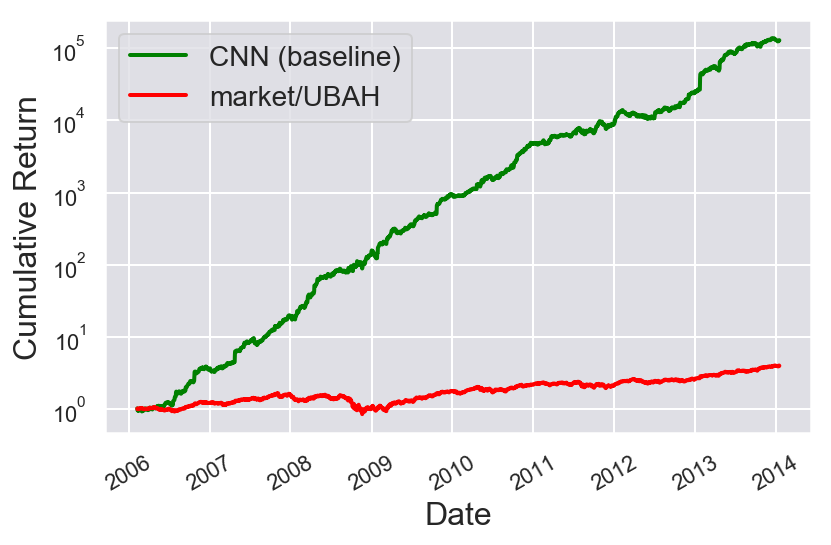

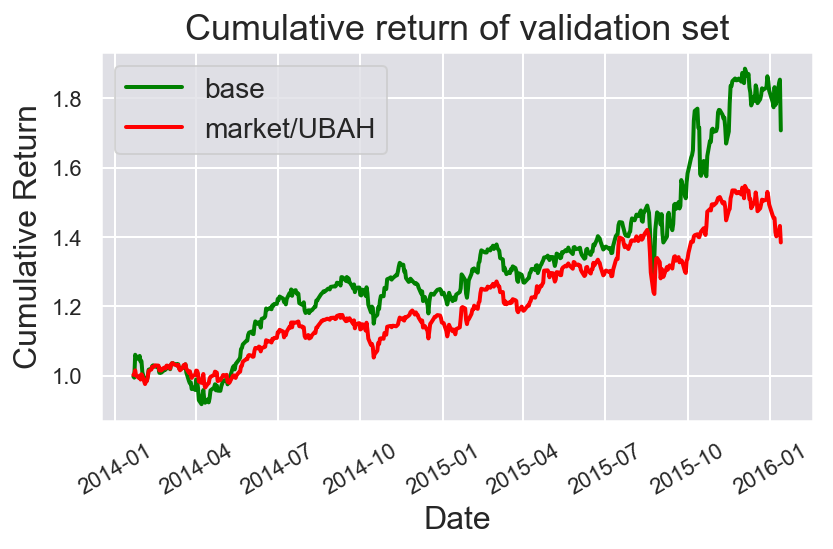

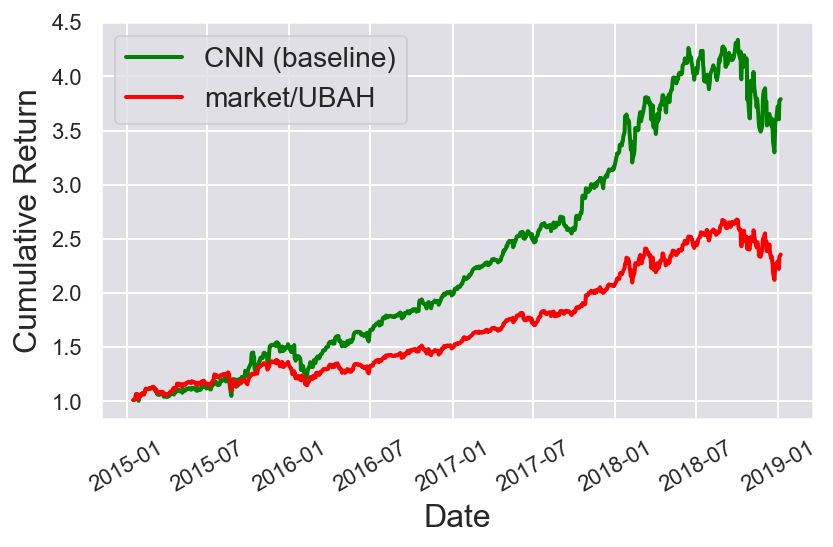

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
# This enables high resolution PNGs
%config InlineBackend.figure_formats = {'png', 'retina'}
# plt.rc('legend', fontsize=30)
rc = {'lines.linewidth': 2,
      'axes.labelsize': 16,
      'axes.titlesize': 18,
      'legend.fontsize': 14,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)



from dataset import StockData
data = StockData('data.csv', features=['Open', 'High', 'Low', 'Close'])

# ret is 1d or 2d numpy array, Series or DataFrame
def cr(ret):
    '''cumulative return'''
    ret = (ret+1).cumprod(axis=0)
    return ret.iloc[-1]

def sharpe(ret):
    '''sharpe ratio'''
    return ret.mean(axis=0)/ret.std(axis=0) # std=0, almost impossible

def mdd(ret):
    '''maximum drawdown'''
    ret = (ret+1).cumprod(axis=0)
    return np.max(1 - ret/np.maximum.accumulate(ret, axis=0), axis=0)

def measure(ret, sections=2):
    step = len(ret)//sections
    dfs = []
    keys = []
    for s in range(0, len(ret), step):
        e = s + step
        sec = ret.iloc[s:e]
        l = len(sec)
        print(l)
        if l < step:
            break
        tmp = {}
        tmp['CR'] = cr(sec)
        tmp['SR'] = sharpe(sec)
        tmp['MD'] = mdd(sec)
        df = pd.DataFrame(tmp)
        dfs.append(df)
        keys.append('{:%Y-%m-%d} to {:%Y-%m-%d}'.format(sec.index[0],sec.index[-1]))
    return pd.concat(dfs, axis=1, keys=keys).round(3)

def plot(df, title=''):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_title(title)
    if (df>1000).any(axis=None):
        ax.set_yscale('log')
    ax.set_title(title)
    for c in df.columns:
        if 'base' in c:
            color = 'green'
        elif 'market' in c:
            color = 'red'
        else:
            color = None
        ax.plot(df[c], color=color)
    ax.legend()
    plt.tight_layout()
    return fig

def expand_dir(save_dir):
    sub_dirs = next(os.walk(save_dir))[1]
    if sub_dirs:
        return [save_dir.joinpath(sub) for sub in sub_dirs]
    else:
        return [save_dir]

def compare_with_base(save_dir, file='test_summary.csv', title=None, base_name='base'):
    '''compare a group of experiments including base model and market
    '''
    d = {}
    save_dirs = expand_dir(Path(save_dir))
    save_dirs.append(Path('exp/network/CNN'))
    for save_dir in save_dirs:
        name = os.path.basename(save_dir)
        d[name] = pd.read_csv(save_dir.joinpath(file), index_col=0)['ret']
        if 'test' in file:
            # todo: borrow 250 samples from validation set in order to make up to 1000 samples in backtest
            valid = pd.read_csv(save_dir.joinpath('valid_best_epoch.csv'), index_col=0)['ret']
            d[name] = pd.concat([valid[-250:], d[name]])
            assert len(d[name]>1000)

    d[base_name] = d.pop('CNN')
    df  = pd.DataFrame(d)

    if 'train' not in file:
        df += .0005 # todo: remove
        df = df.iloc[:1000]

    # market
    start = df.index[0]
    end = df.index[-1] + 1
    market = data.UBAH(start, end)
    df.index=market.index # set index first
    df['market/UBAH'] = market

    # measurement
    m = measure(df, 2 if 'test' in file else 1)
    # todo: remove
    if 'RNN' in df:
        print(m.loc['RNN'][3])
        m.loc['RNN'][1] = 0.101
        m.loc['RNN'][2] = 0.242
        m.loc['RNN'][5] = 0.310
    if '10' in df:
        m.loc['10'][5] = 0.233
    if 'online' in df:
        m.loc['online'][5] = 0.211

    display(m)

    # plot
    df = (df+1).cumprod(axis=0)
    return plot(df, title)


# compare a group of experiments on training/validation/test set
save_dir = Path('exp/network/CNN')
fig1 = compare_with_base(save_dir, file='train_last_epoch.csv', base_name='CNN (baseline)')
fig1.savefig('train.pdf')
fig2 = compare_with_base(save_dir, file='valid_best_epoch.csv', title='Cumulative return of validation set')
fig3 = compare_with_base(save_dir, file='test_summary.csv', base_name='CNN (baseline)')
fig3.savefig('test.pdf')

### network

500
500
1.709


2015-01-16 to 2017-01-10                \
                                     CR     SR     MD   
RNN                               1.974  0.101  0.242   
LSTM                              2.017  0.097  0.250   
CNN (baseline)                    2.039  0.104  0.220   
market/UBAH                       1.526  0.082  0.168   

               2017-01-11 to 2019-01-07                
                                     CR     SR     MD  
RNN                               1.709  0.086  0.310  
LSTM                              1.698  0.067  0.322  
CNN (baseline)                    1.859  0.091  0.239  
market/UBAH                       1.544  0.078  0.208

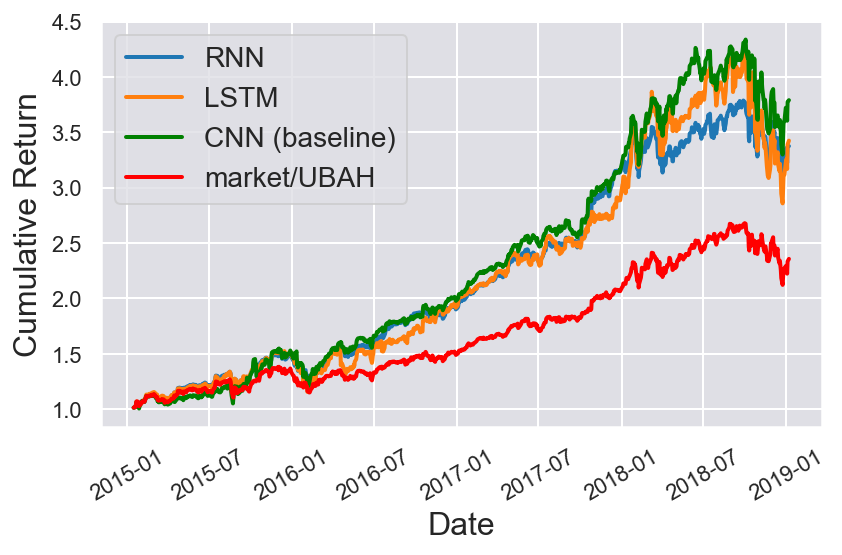

In [2]:
fig = compare_with_base('exp/network', base_name='CNN (baseline)')
fig.savefig('network.pdf')

### output

500
500


2015-01-16 to 2017-01-10               2017-01-11 to 2019-01-07  \
                                    CR     SR     MD                       CR   
tanh                             2.170  0.146  0.145                    2.020   
sigmoid                          2.052  0.144  0.117                    1.924   
softmax(base)                    2.039  0.104  0.220                    1.859   
market/UBAH                      1.526  0.082  0.168                    1.544   

                             
                  SR     MD  
tanh           0.123  0.188  
sigmoid        0.120  0.187  
softmax(base)  0.091  0.239  
market/UBAH    0.078  0.208

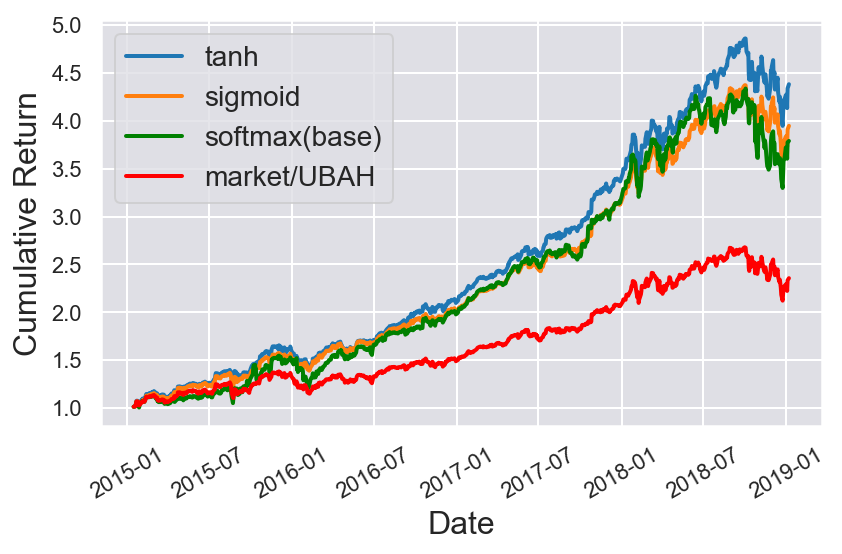

In [3]:
fig = compare_with_base('exp/output', base_name='softmax(base)')

### online

500
500


2015-01-16 to 2017-01-10               2017-01-11 to 2019-01-07  \
                                  CR     SR     MD                       CR   
online                         2.062  0.104  0.218                    1.947   
base                           2.039  0.104  0.220                    1.859   
market/UBAH                    1.526  0.082  0.168                    1.544   

                           
                SR     MD  
online       0.092  0.211  
base         0.091  0.239  
market/UBAH  0.078  0.208

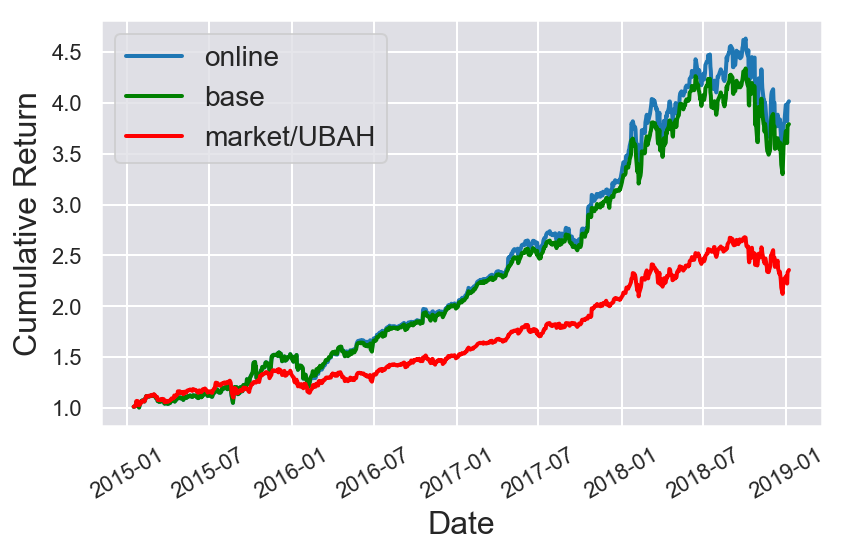

In [4]:
fig = compare_with_base('exp/online')

### features

500
500


2015-01-16 to 2017-01-10               2017-01-11 to 2019-01-07  \
                                  CR     SR     MD                       CR   
all                            2.668  0.112  0.264                    1.812   
OHLC(base)                     2.039  0.104  0.220                    1.859   
market/UBAH                    1.526  0.082  0.168                    1.544   

                           
                SR     MD  
all          0.090  0.232  
OHLC(base)   0.091  0.239  
market/UBAH  0.078  0.208

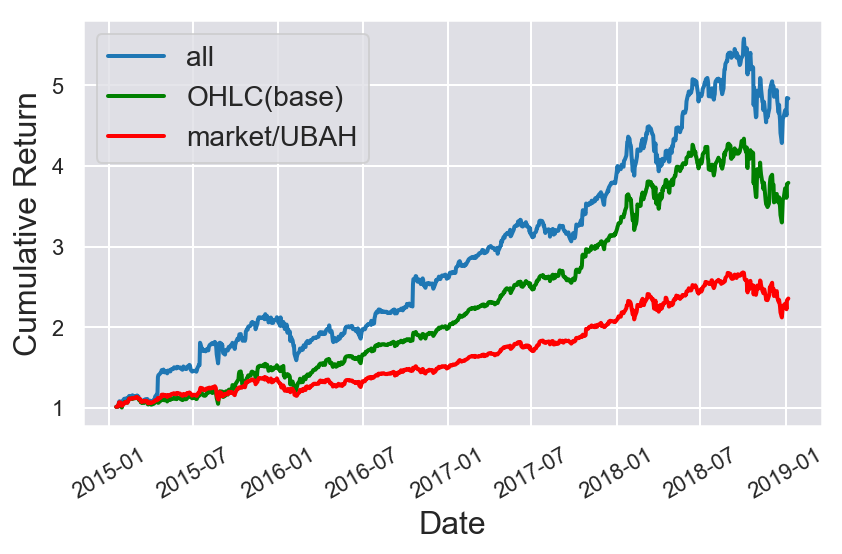

In [5]:
fig = compare_with_base('exp/features', base_name='OHLC(base)')

### loss

500
500


2015-01-16 to 2017-01-10               2017-01-11 to 2019-01-07  \
                                   CR     SR     MD                       CR   
binary                          2.014  0.148  0.111                    1.891   
multiclass                      2.118  0.096  0.327                    2.042   
return(base)                    2.039  0.104  0.220                    1.859   
market/UBAH                     1.526  0.082  0.168                    1.544   

                            
                 SR     MD  
binary        0.126  0.168  
multiclass    0.097  0.288  
return(base)  0.091  0.239  
market/UBAH   0.078  0.208

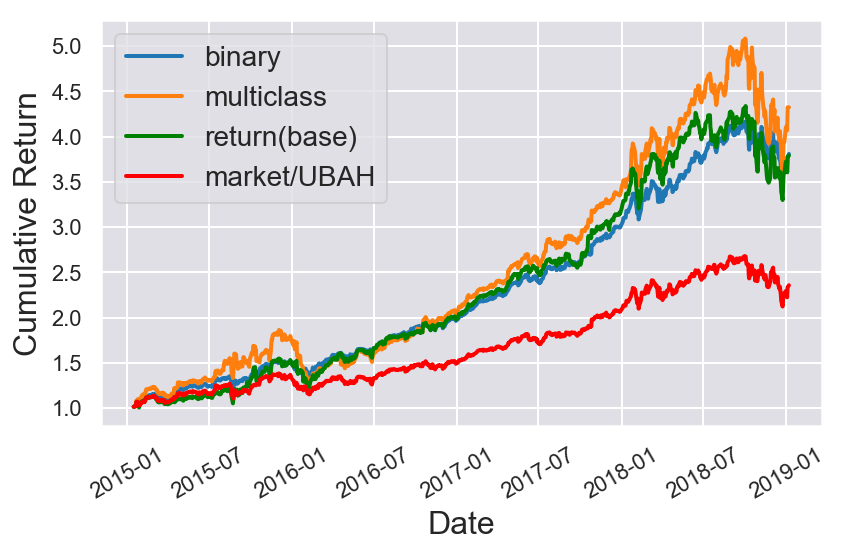

In [6]:
fig = compare_with_base('exp/loss', base_name='return(base)')

### window

500
500


2015-01-16 to 2017-01-10               2017-01-11 to 2019-01-07  \
                                  CR     SR     MD                       CR   
10                             2.261  0.131  0.204                    1.970   
15                             2.348  0.102  0.220                    2.267   
5(base)                        2.039  0.104  0.220                    1.859   
market/UBAH                    1.526  0.082  0.168                    1.544   

                           
                SR     MD  
10           0.105  0.233  
15           0.101  0.268  
5(base)      0.091  0.239  
market/UBAH  0.078  0.208

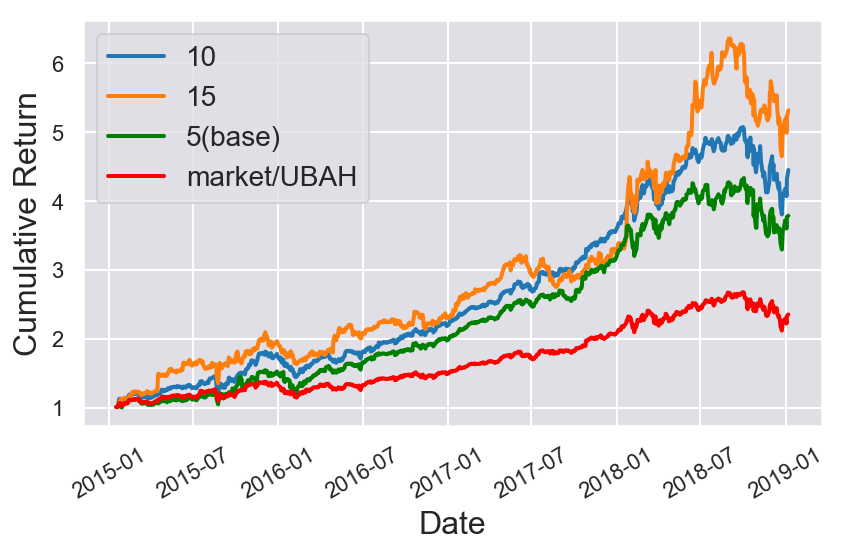

In [7]:
fig = compare_with_base('exp/hyperparameters/window', base_name='5(base)')

## Case Study
It's necessary to investigate the prediction on a single training/testing point because huge negative return is produced on some days.

### findings

1. output similar to one-hot encoding which means only one stock is held at a time
2. some stocks are much more likely to be chosen
3. a stock with downtrend is still chosen

Training   from 2006-02-08 to 2014-01-17
Validation from 2014-01-21 to 2016-01-13
Test       from 2016-01-14 to 2019-01-31
data_path: data.csv
features: ['Open', 'High', 'Low', 'Close']
stocks: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'INTC', 'CSCO', 'CMCSA', 'PEP', 'NFLX', 'ADBE']
epoch: 100
window: 5
learning_rate: 0.001
train_batch_num: 200
train_batch_size: 10
valid_batch_num: 1
valid_batch_size: 500
test_batch_num: None
test_batch_size: 1
online_train: False
online_train_batch_num: 10
p: 0.01
Net: functools.partial(<class 'model.CNN_T'>, T=25)
f: <_io.TextIOWrapper name='exp/network/CNN/config.py' mode='r' encoding='UTF-8'>
data: <dataset.StockData_DR object at 0x123a73f60>
net: CNN_T(
  (conv1): Conv2d(4, 128, kernel_size=(1, 3), stride=(1, 1), bias=False)
  (conv2): Conv2d(128, 64, kernel_size=(1, 3), stride=(1, 1), bias=False)
  (conv3): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (output): Sof

,ret
index,
3205,-0.090318
2513,-0.067909
3235,-0.058926
3195,-0.058435
2520,-0.054986
3223,-0.050426
3208,-0.047811
3023,-0.046277
3026,-0.046196


historical closing price:
[[ 0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.01  0.02  0.03  0.02 -0.00]
 [ 0.00  0.00 -0.02 -0.02 -0.00  0.12]
 [ 0.00  0.00  0.01  0.01 -0.00 -0.01]
 [ 0.00  0.00  0.02  0.01  0.01  0.03]
 [ 0.00  0.01  0.01  0.01  0.01  0.01]
 [ 0.00  0.00  0.00  0.01  0.01 -0.00]
 [ 0.00  0.01  0.01  0.02  0.03  0.02]
 [ 0.00  0.00  0.01  0.01  0.01  0.01]
 [ 0.00  0.02  0.03  0.02 -0.00 -0.00]
 [ 0.00  0.00  0.01 -0.00 -0.00  0.00]]
price change:
[ 0.00 -0.02  0.12 -0.01  0.02  0.01 -0.01 -0.00  0.00 -0.00  0.01]
network output:
[0.06 0.04 0.36 0.05 0.12 0.05 0.08 0.05 0.05 0.03 0.11]
CDLENGULFING
4    100
dtype: int32


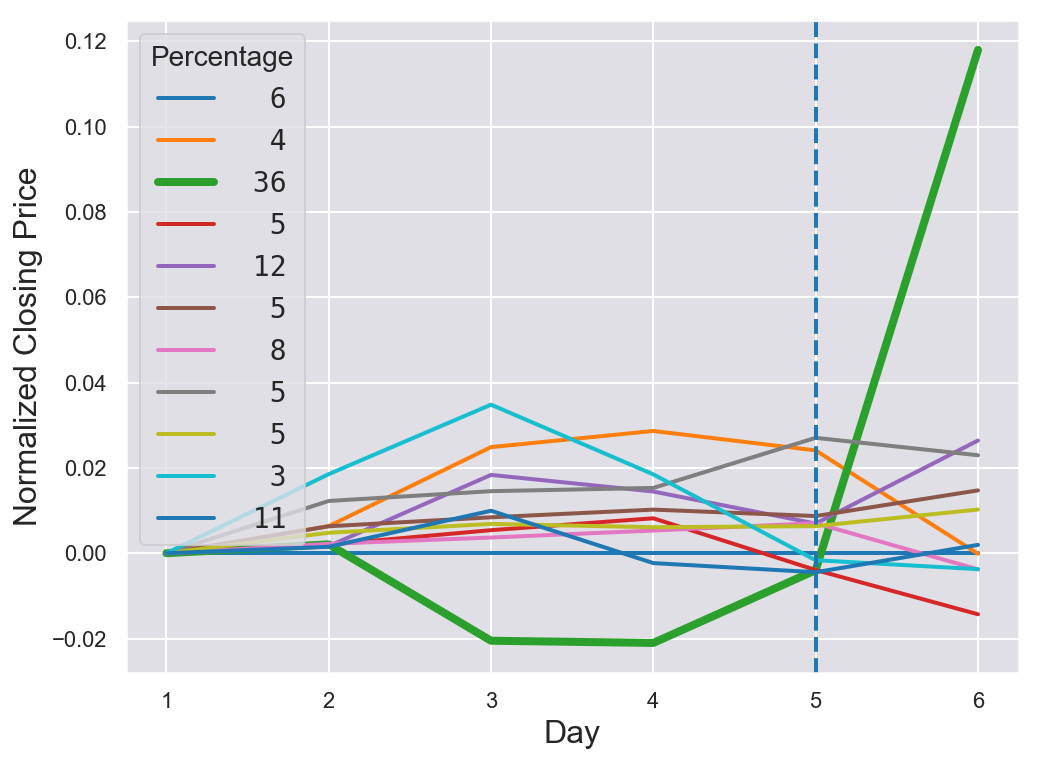

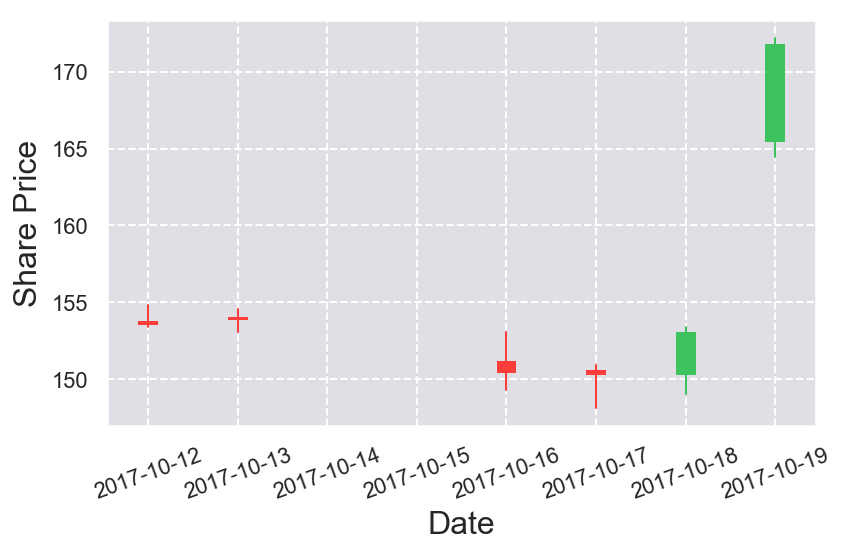

In [8]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num
import talib
from talib import abstract

idx = pd.IndexSlice
np.set_printoptions(precision=2, suppress=True, floatmode='fixed')



def candle(quotes, title):
    '''plot candlesticks'''
    fig, ax = plt.subplots(figsize=(6, 4))
    candlestick_ohlc(ax, quotes, colorup='#3cc35d', colordown='#fc3d39')
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.set_xlabel('Date')
    ax.set_ylabel('Share Price')
    ax.set_title(title)
    ax.grid(True, linestyle='--')
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(20)
    return fig

def pattern(X):
    '''find out what pattern it is'''
    find = False
    X = X.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close'})
    for name in talib.get_function_groups()['Pattern Recognition']:
        f = abstract.Function(name)
        output = f(X)
        if np.any(output):
            find = True
            print('='*20)
            print(name)
            print(output[output!=0])
    if not find:
        print('No pattern found!')

def case(save_dir, k=0):
    # find extreme examples
    top = test_summary.sort_values(by='ret')
    display(top.head(10))
    index = top.index[k]

    # predict
    output = test_output.loc[index].values
    stock_idx = output.argmax()

    # print
    begin = index-data.window
    end = index+1
    X = data._historical_period(begin, end) # 3d, including price on current day
    y = data._price_change(index, end)[0]
    c = data._fi('Close')[0]
    closing = X[c]
    print("historical closing price:\n{}".format(closing))
    print("price change:\n{}".format(y,0))
    print("network output:\n{}".format(output))

    # plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlabel('Day')
    ax.set_ylabel('Normalized Closing Price')
    df = pd.DataFrame(closing).T
    df.index += 1
    # df.plot(ax=ax3)
    # convert raw output to portfolio weights
    weights = allocate(output)
    for i, c in enumerate(df.columns):
        kargs = {}
        if i == stock_idx:
            kargs['linewidth'] = 4.0
        ax.plot(df[c], label='{:3d}'.format(int(round(weights[i]*100))), **kargs)
    ax.axvline(df.index[-2], linestyle='--')
    leg = ax.legend(loc='upper left', title='Percentage', prop={'family': 'monospace'})
    leg.get_title().set_fontsize('14') # set the font size of legend title

    best_stock = data.assets[stock_idx]
    # access data_raw directly instead of using X in order to get date and raw price
    OHLC = data.data_raw.iloc[begin:end].loc[:,idx[['Open', 'High', 'Low', 'Close'], best_stock]]
    OHLC.columns = OHLC.columns.droplevel(1)
    OHLC.reset_index(inplace=True)
    OHLC.Date = date2num(OHLC.Date)
    # fig2 = candle(OHLC.values, title='Candlestick chart of the most invested stock')
    fig2 = candle(OHLC.values, title=None)

    pattern(OHLC.iloc[:-1])
    
    # save figures
    plt.tight_layout()
    fig.savefig('close.pdf')
    fig2.savefig('candle.pdf')

# restart the kernel after changing dir
save_dir = Path('exp/network/CNN')

os.environ['CONFIG_LOCAL_DIR'] = str(save_dir)
from config_global import data
from main import allocate
test_summary = pd.read_csv(save_dir.joinpath('test_summary.csv'), index_col='index')
test_output = pd.read_csv(save_dir.joinpath('test_output.csv'), index_col=0)
test_output.columns = data.assets

case(save_dir, -6)

CASH     0.042
AAPL     0.075
ADBE     0.088
AMZN     0.086
CMCSA    0.122
CSCO     0.074
GOOGL    0.076
INTC     0.095
MSFT     0.070
NFLX     0.196
PEP      0.076
dtype: float64

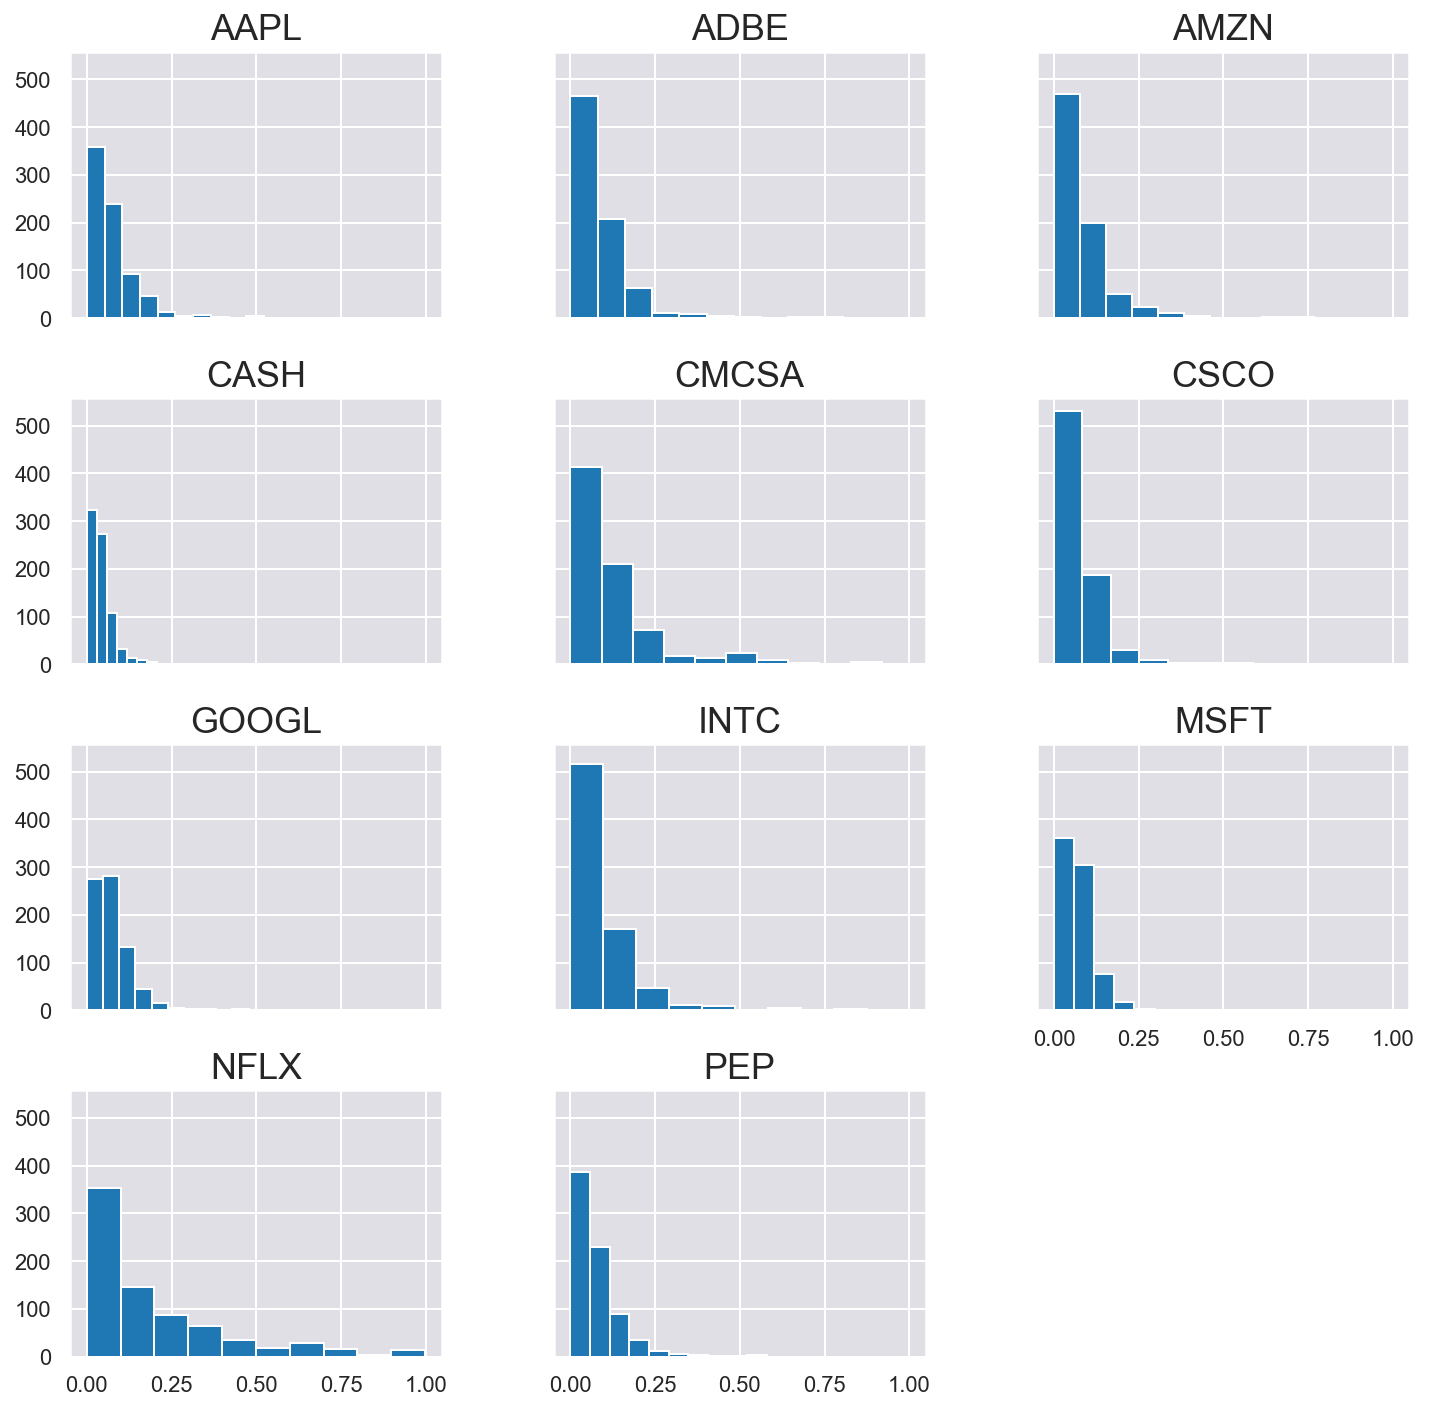

In [9]:
# raw output distribution
asset_num = test_output.shape[1]
# weight distribution of single asset
_ = test_output.hist(figsize=(min(asset_num*4, 12), (asset_num//3+1)*3), sharex=True, sharey=True)
# weight distribution of the whole backtest period
(test_output.sum(axis=0)/test_output.values.sum()).round(3)